# Long Short-Term Memory (LSTM) Model

In [1]:
# basic imports
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


# metrics
from numpy import mean
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# import modules
from modules.time_series_functions import resample_series # (series, time_period='day', measure='revenue')
from modules.time_series_functions import create_date_features # (timeseries_df)
from modules.time_series_functions import add_lagged_features # (timeseries_df, num_lag)

# visualizations
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style='darkgrid', context='talk')

# time series
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [2]:
# loading in dataset:
df = pd.read_csv(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\data\cleaned_data.csv', parse_dates=['date'])
df.head()

,order_id,date,item_code,quantity,unit_price,unit_cogs,country,item_name,style,name,group0,group1,group2,category,gender,age,sales_revenue,gross_profit,profit_margin,region
0,2000093388,2020-04-24,ZB00089178,1,5.829845,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,5.829845,3.620543,0.621036,Central Europe
1,1900182328,2019-11-04,ZB00089178,1,5.686483,0.000000,Slovakia,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,5.686483,5.686483,1.000000,Central Europe
2,1900186164,2019-11-10,ZB00089178,1,4.965116,2.373643,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.965116,2.591473,0.521936,Central Europe
3,2000058563,2020-03-07,ZB00089178,1,4.965116,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.965116,2.755814,0.555035,Central Europe
4,2000297106,2020-11-24,ZB00089178,1,4.772868,2.364341,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.772868,2.408527,0.504629,Central Europe


In [3]:
df.dtypes

order_id                  int64
date             datetime64[ns]
item_code                object
quantity                  int64
unit_price              float64
unit_cogs               float64
country                  object
item_name                object
style                    object
name                     object
group0                   object
group1                   object
group2                   object
category                 object
gender                   object
age                      object
sales_revenue           float64
gross_profit            float64
profit_margin           float64
region                   object
dtype: object

In [4]:
df.shape

(1333384, 20)

## Data Preperation & More Feature Engineering

In [5]:
df = resample_series(df, 'day', 'revenue')
df.head()

,date,sales_revenue
0,2019-06-01,4033.781335
1,2019-06-02,49.458527
2,2019-06-03,1323.282072
3,2019-06-04,68572.183865
4,2019-06-05,65144.273667


In [6]:
df.shape

(959, 2)

In [7]:
df.head()

,date,sales_revenue
0,2019-06-01,4033.781335
1,2019-06-02,49.458527
2,2019-06-03,1323.282072
3,2019-06-04,68572.183865
4,2019-06-05,65144.273667


In [8]:
lstm_df = df.copy()

# create 'prev_sales_revenue' column that shifts the revenue by one and then finds the difference between last and current revenue
lstm_df['prev_sales_revenue'] = lstm_df['sales_revenue'].shift(1)
lstm_df = lstm_df.dropna()
lstm_df['difference'] = (lstm_df['sales_revenue'] - lstm_df['prev_sales_revenue'])

In [9]:
lstm_df.head()

,date,sales_revenue,prev_sales_revenue,difference
1,2019-06-02,49.458527,4033.781335,-3984.322808
2,2019-06-03,1323.282072,49.458527,1273.823545
3,2019-06-04,68572.183865,1323.282072,67248.901793
4,2019-06-05,65144.273667,68572.183865,-3427.910198
5,2019-06-06,18783.094790,65144.273667,-46361.178878


In [10]:
# # use function from module folder in time_series_functions.py file to add lags as features
# lstm_df = add_lagged_features (lstm_df, 90)

In [11]:
# drop 'prev_sales_revenue' column as the 'difference' columns is more useful
lstm_df.drop('prev_sales_revenue', axis=1,inplace=True)

In [12]:
lstm_df.head()

,date,sales_revenue,difference
1,2019-06-02,49.458527,-3984.322808
2,2019-06-03,1323.282072,1273.823545
3,2019-06-04,68572.183865,67248.901793
4,2019-06-05,65144.273667,-3427.910198
5,2019-06-06,18783.094790,-46361.178878


In [13]:
train = lstm_df[lstm_df['date'] < pd.Timestamp('2021-06-01')].drop(['sales_revenue','date'],axis=1).values
test = lstm_df[lstm_df['date'] >= pd.Timestamp('2021-06-01')].drop(['sales_revenue','date'],axis=1).values

In [14]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

# reshape training set
train = train.reshape(train.shape[0], train.shape[1])
train_scaled = scaler.transform(train)

# reshape test set
test = test.reshape(test.shape[0], test.shape[1])
test_scaled = scaler.transform(test)

In [15]:
test_scaled

array([[-9.56378707e-02],
       [ 1.92643133e-02],
       [ 4.05493426e-02],
       [ 4.41607796e-02],
       [ 1.01850751e-01],
       [ 3.01401067e-01],
       [-2.56127771e-02],
       [ 1.16985115e-01],
       [-3.17461872e-02],
       [-7.06839149e-02],
       [-2.23810952e-05],
       [ 2.28982787e-02],
       [ 2.58356650e-01],
       [ 1.68636119e-02],
       [ 1.24021396e-01],
       [-7.49879499e-03],
       [-1.14966677e-01],
       [-5.52239278e-02],
       [-3.92316307e-02],
       [ 2.46257954e-01],
       [ 1.08393121e-01],
       [ 2.33050338e-02],
       [-6.24050546e-02],
       [ 4.51505972e-02],
       [ 1.91945316e-02],
       [ 1.04182631e-01],
       [ 1.18886232e-01],
       [ 1.48885658e-01],
       [-6.45101291e-02],
       [ 1.00561943e-01],
       [ 8.33447710e-02],
       [-6.76750983e-02],
       [ 1.80938791e-02],
       [ 1.67182488e-01],
       [ 1.48233553e-01],
       [ 6.74038166e-02],
       [ 7.15379990e-02],
       [ 8.31145539e-02],
       [ 6.9

## Moving Average Model (Baseline)

In [16]:
series = df['sales_revenue']

# prepare situation
X = series.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length) if isinstance(history[i], float)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=1802.173978, expected=68572.183865
predicted=23314.974821, expected=65144.273667
predicted=45013.246535, expected=18783.094790
predicted=50833.184108, expected=10750.820614
predicted=31559.396357, expected=37.927132
predicted=9857.280845, expected=0.000000
predicted=3596.249249, expected=35543.475183
predicted=11860.467438, expected=45805.924673
predicted=27116.466619, expected=6162.000643
predicted=29170.466833, expected=30264.056303
predicted=27410.660540, expected=11633.736118
predicted=16019.931022, expected=130.669767
predicted=14009.487396, expected=114.759900
predicted=3959.721929, expected=81577.233622
predicted=27274.221097, expected=21658.992539
predicted=34450.328687, expected=22139.608087
predicted=41791.944749, expected=30813.705778
predicted=24870.768801, expected=13640.379609
predicted=22197.897825, expected=15385.245016
predicted=19946.443468, expected=22898.206141
predicted=17307.943589, expected=21860.061968
predicted=20047.837708, expected=20130.954256
pred

In [17]:
# MSE
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 237588430.131


In [18]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 15413.904


In [19]:
# calculate R-squared
r2 = r2_score(test, predictions)
print(f'R-squared: {r2:.4f}')

R-squared: 0.7701


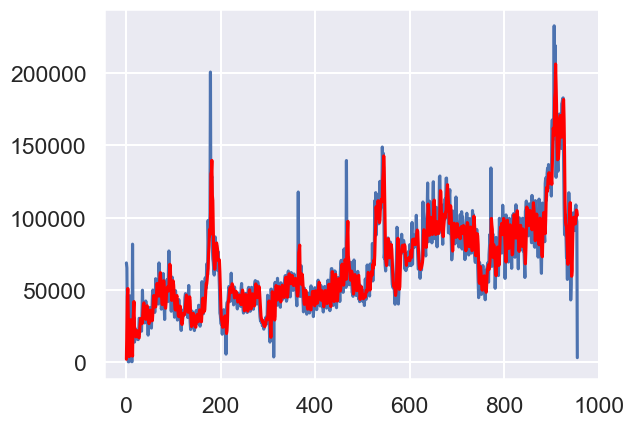

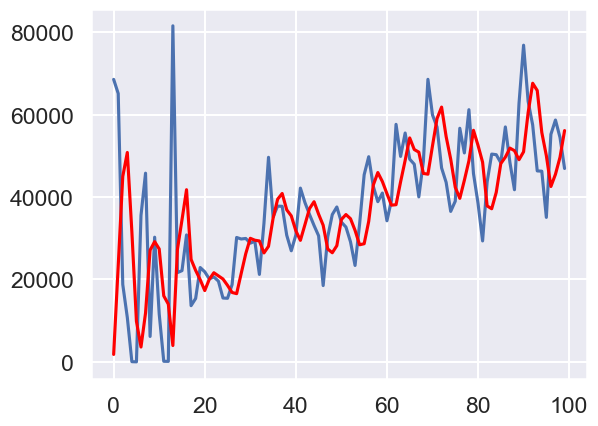

In [20]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# zoom plot
pyplot.plot(test[0:100])
pyplot.plot(predictions[0:100], color='red')
pyplot.show()

## LSTM Model

In [21]:
# train:
X_train, y_train = train_scaled[:, 1:], train_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# test:
X_test, y_test = test_scaled[:, 1:], test_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [22]:
model = Sequential()

model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
730/730 [==============================] - 2s 1ms/step - loss: 0.0182
Epoch 2/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 3/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 4/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 5/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 6/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 7/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 8/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 9/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 10/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 11/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 12/100
730/730 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 13/100


In [23]:
y_pred=model.predict(X_test, batch_size=1)

228/228 [==============================] - 0s 806us/step


In [26]:
# reshape

y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

# inverse transform
pred_test = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
    
# reshape pred_test_set
pred_test = np.array(pred_test)
pred_test = pred_test.reshape(pred_test.shape[0], pred_test.shape[2])

# inverse transform
pred_test_inverted = scaler.inverse_transform(pred_test)

[[0.05983949]]
[[0.05984923]]
[[0.05985563]]
[[0.0598598]]
[[0.05986251]]
[[0.05986425]]
[[0.05986536]]
[[0.05986606]]
[[0.0598665]]
[[0.05986678]]
[[0.05986694]]
[[0.05986705]]
[[0.05986711]]
[[0.05986714]]
[[0.05986715]]
[[0.05986716]]
[[0.05986717]]
[[0.05986717]]
[[0.05986717]]
[[0.05986717]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716]]
[[0.05986716

In [30]:
# dataframe that shows the forecasted sales revenue
result_list = []

sales_revenue_date = list(df.date)

act_sales = list(df.sales_revenue)
for index in range(0,len(pred_test_inverted)):
    result_dict = {}
    result_dict['forecast_value'] = int(pred_test_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_revenue_date[index+1]
    result_list.append(result_dict)
    
df_final = pd.DataFrame(result_list)

In [31]:
df_final["date"] = df_final["date"] + timedelta(days=730)
df_final.head()

,forecast_value,date
0,4050,2021-06-01
1,67,2021-06-02
2,1341,2021-06-03
3,68591,2021-06-04
4,65163,2021-06-05


In [32]:
sales_revenue_forecast = pd.merge(df, df_final , on='date',how='left')

## Visualizations

In [33]:
plt.rcParams.update({'font.size': 14})

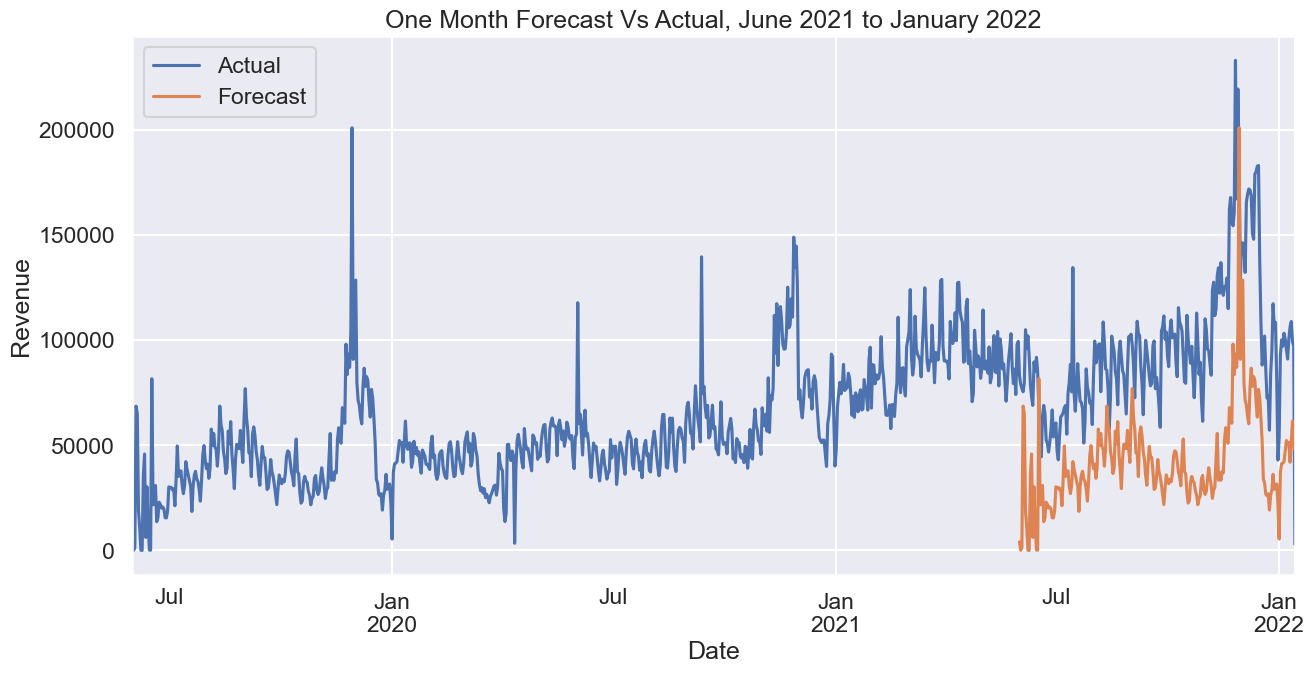

In [34]:
f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(7)
f.set_figwidth(15)

sales_revenue_forecast.plot(x='date', y='sales_revenue', label='Actual', ax=ax)
sales_revenue_forecast.plot(x='date', y='forecast_value', label='Forecast', ax=ax)

plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.title('One Month Forecast Vs Actual, June 2021 to January 2022')

plt.savefig(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\images/lstm_onemonth_.png')

Text(0.5, 1.0, 'One Month Forecast Vs Actual, August 1 to 30, 2021')

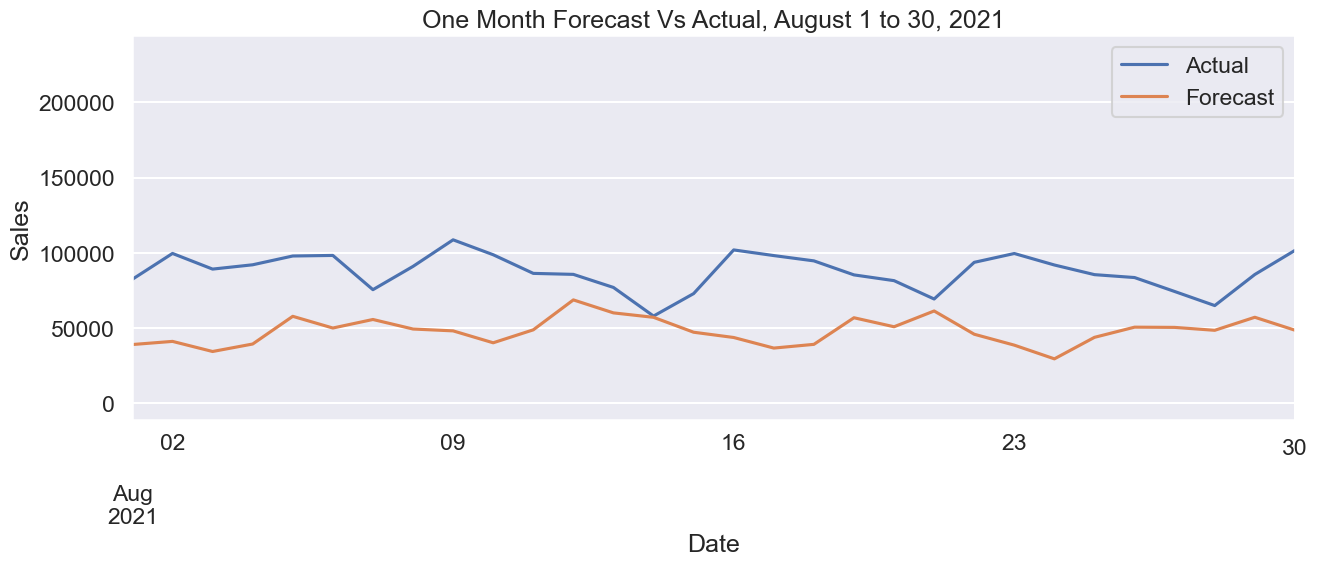

In [35]:
f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)

sales_revenue_forecast.plot(x='date', y='sales_revenue', label='Actual', ax=ax)
sales_revenue_forecast.plot(x='date', y='forecast_value', label='Forecast', ax=ax)

plt.legend()
ax.set_xbound(lower=dt.date(2021,8,1), upper=dt.date(2021,8,30))
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('One Month Forecast Vs Actual, August 1 to 30, 2021')

Text(0.5, 1.0, 'One Month Forecast Vs Actual, Nov 1 to Dec 30, 2021')

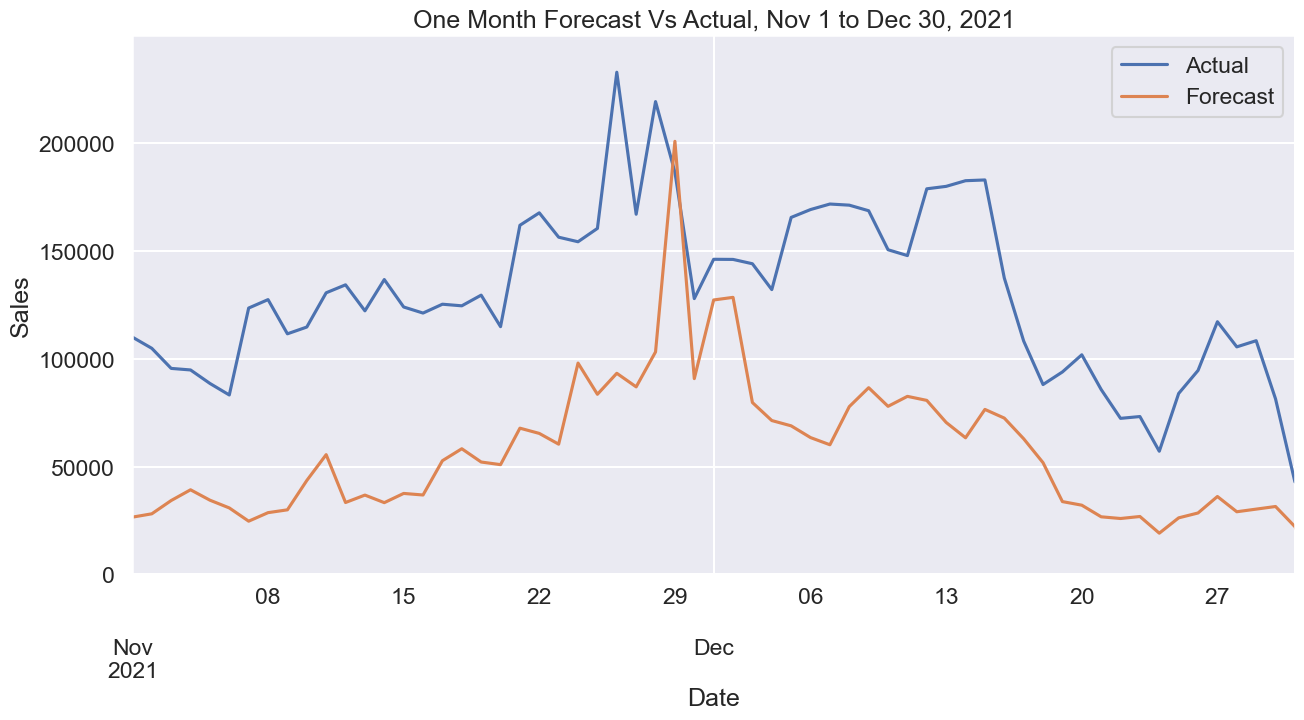

In [36]:
f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(7)
f.set_figwidth(15)

sales_revenue_forecast.plot(x='date', y='sales_revenue', label='Actual', ax=ax)
sales_revenue_forecast.plot(x='date', y='forecast_value', label='Forecast', ax=ax)

plt.legend()
ax.set_xbound(lower=dt.date(2021,11,1), upper=dt.date(2021,12,31))
ax.set_ybound(lower=0, upper=249999)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('One Month Forecast Vs Actual, Nov 1 to Dec 30, 2021')

### Metrics 

In [37]:
from sklearn.metrics import r2_score

# calculate r2 score
r2 = r2_score(y_test, y_pred)

print("R-squared: ", r2)

ValueError: Found array with dim 3. None expected <= 2.

## LSTM Model 2.0?

In [38]:
# set random seed for reproducibility
np.random.seed(42)

# split the data into train and test sets
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['sales_revenue']])
test_scaled = scaler.transform(test_data[['sales_revenue']])

# create function to convert time series data into a supervised learning problem
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps, :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# define time step for the LSTM model
time_steps = 7

# create the training set
X_train, y_train = create_dataset(train_scaled, train_scaled, time_steps)

# create the test set
X_test, y_test = create_dataset(test_scaled, test_scaled, time_steps)

# define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse')

# train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss:.4f}')

# make predictions on the test set
y_pred = model.predict(X_test)

# inverse scale the predictions and actual values to their original form
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50
43/43 [==============================] - 2s 13ms/step - loss: 0.0150 - val_loss: 0.0038
Epoch 2/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 3/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 4/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 5/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 6/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 7/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 8/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 9/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 10/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 11/50
43/43 

In [39]:
# calculate R-squared
r2 = r2_score(y_test_inv, y_pred_inv)
print(f'R-squared: {r2:.4f}')

R-squared: 0.6764


In [40]:
# calculate the root mean squared error (RMSE)
rmse = np.sqrt(tf.keras.metrics.mean_squared_error(y_test_inv, y_pred_inv))
print(f'RMSE: {float(rmse[0]):.4f}')

RMSE: 6221.1484


In [41]:
smape = np.mean(np.abs(y_pred_inv - y_test_inv) / ((np.abs(y_test_inv) + np.abs(y_pred_inv)) / 2)) * 100
print(f'SMAPE: {smape:.4f}%')

SMAPE: 13.2382%


In [42]:
# MSE
error = mean_squared_error(y_test_inv, y_pred_inv)
print('Test MSE: %.3f' % error)

Test MSE: 342815512.568


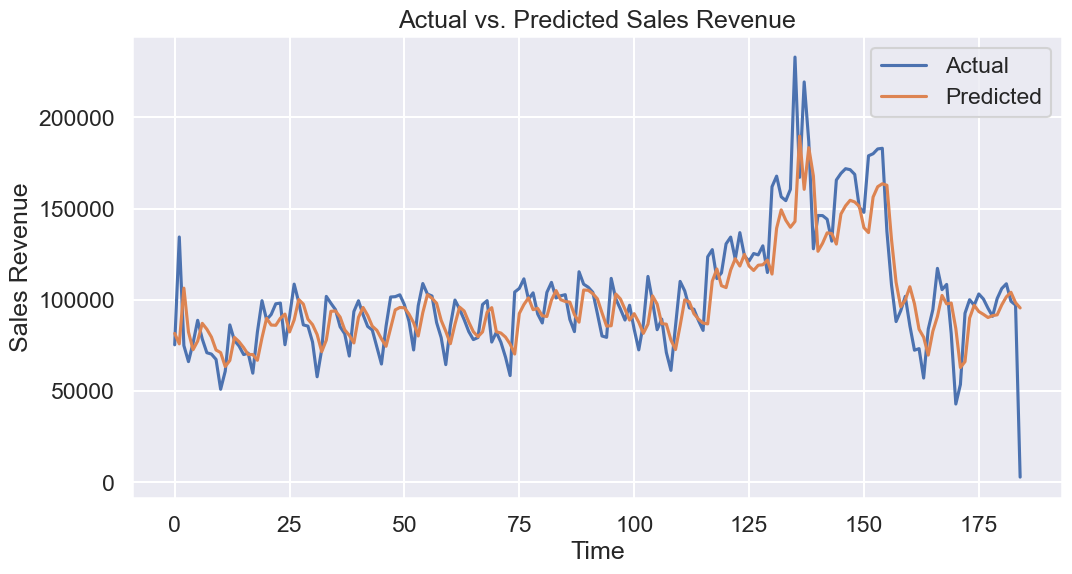

In [43]:
import matplotlib.pyplot as plt

# plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs. Predicted Sales Revenue')
plt.xlabel('Time')
plt.ylabel('Sales Revenue')
plt.legend()
plt.show()